<a href="https://colab.research.google.com/github/safaabuzaid/xai-brain-tumor-classification/blob/main/04_Model_Improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Model Improvement & Advanced Analysis

This notebook focuses on taking the baseline CNN further and making it more robust, interpretable, and professional:

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_root = "/content/drive/MyDrive/Data/MRI_data/data_preprocessed"
train_root = f"{data_root}/Training"
test_root = f"{data_root}/Testing"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_root, transform=transform)
test_dataset = datasets.ImageFolder(test_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

###1. Handle Class Imbalance

Why: The dataset has imbalanced classes, which can make the model biased toward the majority class.

Strategies:

- Class weights in the loss function → penalize mistakes on minority classes more *[This on used]*

- Oversampling / augmentation → create more images for minority classes

In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Get the labels from the dataset
labels = train_dataset.targets

# compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# define loss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

### 2. Train with Advanced Architecture

ResNet18 is solid, but architectures like EfficientNet, VGG19, or DenseNet may extract more meaningful features and improve accuracy.

#### I. EfficientNet

In [12]:
import torchvision.models as models

model = models.efficientnet_b0(pretrained=True)

#fine tuning the model
#freeze all layers
for param in model.parameters():
    param.requires_grad = False

#unfreeze lst two blocks
for param in model.features[-2:].parameters():
    param.requires_grad = True

#replace last layer
num_features = model.classifier[1].in_features
num_classes = 4
model.classifier[1] = nn.Linear(num_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [14]:
#Train the model

num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

Epoch 1/15, Loss: 0.6430, Accuracy: 80.23%
Epoch 2/15, Loss: 0.3204, Accuracy: 89.30%
Epoch 3/15, Loss: 0.2461, Accuracy: 91.44%
Epoch 4/15, Loss: 0.1939, Accuracy: 93.52%
Epoch 5/15, Loss: 0.1611, Accuracy: 94.54%
Epoch 6/15, Loss: 0.1400, Accuracy: 95.31%
Epoch 7/15, Loss: 0.1157, Accuracy: 96.10%
Epoch 8/15, Loss: 0.0964, Accuracy: 96.92%
Epoch 9/15, Loss: 0.0805, Accuracy: 97.58%
Epoch 10/15, Loss: 0.0814, Accuracy: 97.43%
Epoch 11/15, Loss: 0.0646, Accuracy: 98.00%
Epoch 12/15, Loss: 0.0559, Accuracy: 98.28%
Epoch 13/15, Loss: 0.0522, Accuracy: 98.37%
Epoch 14/15, Loss: 0.0475, Accuracy: 98.74%
Epoch 15/15, Loss: 0.0425, Accuracy: 98.58%


In [15]:
# Evaluation on test set

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100*correct/total:.2f}%")

Test Accuracy: 96.80%


### 3. Evaluation

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

preds = []
targets = []
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# collect predictions
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

print(classification_report(targets, preds, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.98      0.93      0.95       300
  meningioma       0.93      0.94      0.93       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



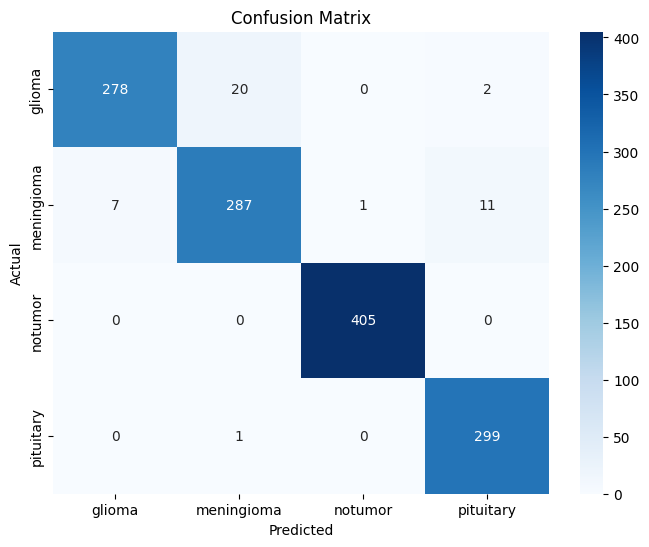

In [18]:
#plot confusion matrix

cm = confusion_matrix(targets, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [22]:
torch.save(model, "/content/drive/MyDrive/Data/efficient_full_model.pth")

### Notebook Summary

- Handeled class imbalance using class weight in the loss function
- Trained **EfficientNet** with **fine_tuning of the last two blocks.**
- Training Accuracy: **98.58%**
- Testing Accuracy: **96.80%**
- Evaluated model peformance with **precition, recall, F1-score** for each class.
- visualized prediction using **confusion matrix.**

Conclusion:

The model generlized well, with no significant overfitting observed.